# Threshold optimization (adaptive)
For each test season from 2014NH to 2020SH, we will optime the threshold based on predictions of the model on the most recent past three seasons (adaptively).

**Note**: The non-adaptive alternative is to optimize the threshold based on only the four validation seasons from 2012NH to 2013SH.

**Note**: This adaptive implementation will not result in data leakage problem, as for any test season, we will use the information of only the past three seasons for classifying the virus-antiserum pairs of the test season; the predicted NHTs of the test season will remain the same as predicted before in notebook "Fig2_model_evaluation".

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import utilities   # self defined functions
import gc

## Variables

In [2]:
mut_mat     = "GIAG010101"   # mutation matrix
Seasons     = [str(year)+s for year in range (2012, 2021) for s in ["NH", "SH"]]   # seasons from 2012NH to 2020SH
metadata    = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name  = 'AdaBoost'   # the type of model to be used

## Paths and filenames

In [3]:
# paths
path_result = "../results/SuppFig5b_optimize_threshold/"   # results will be saved in this directory
Path(path_result+"threshold_curves/").mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
scores_fn    = path_result + f"SuppFig5b_testScores_{mut_mat}_threshold_YJS.csv"   # to save performance scores for test dataset
threshold_fn = path_result + "SuppFig5b_thresholds.csv"   # to save thresholds
fig_fn       = path_result + "SuppFig5b_threshold_YJS_classification.svg"   # to save figure

## Read predicted NHTs by the AdaBoost model on validation and test seasons

In [4]:
# read validation data with predicted NHTs by the proposed RF model
data_valid = pd.read_csv(path_result + f"output_validSeasons_{mut_mat}.csv")

# read test data with predicted NHTs by the proposed RF model
data_test  = pd.read_csv(f"../results/Fig2_model_evaluation/output_testSeasons_{mut_mat}.csv")

# combine the data
data = pd.concat((data_valid, data_test), ignore_index=True)

del data_valid, data_test
gc.collect()

0

## Threshold optimization
- For each test season from 2014NH to 2020SH
 - Find threshold based on validation data of most recent past 3 seasons
 - Save threshold curve for each season
 - Based on the threshold, classify virus-antiserum pairs in test dataset
 - Compute performance scores
- Save threshold values
- Compute average performance scores

D:\Dropbox\Research-Awais\Methods Paper\Codes and Figures\src_AdaBoost\utilities.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (y_label=='') & (y_pred_label==''):
D:\Dropbox\Research-Awais\Methods Paper\Codes and Figures\src_AdaBoost\utilities.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (y_label=='') & (y_pred_label==''):
D:\Dropbox\Research-Awais\Methods Paper\Codes and Figures\src_AdaBoost\utilities.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (y_label=='') & (y_pred_label==''):
D:\Dropbox\Research-Awais\Methods Paper\Codes and Figures\src_AdaBoost\utilities.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (y_label==''

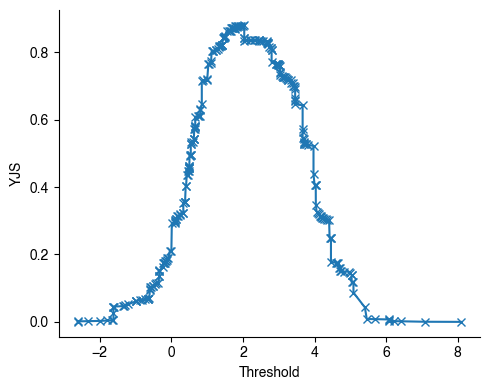

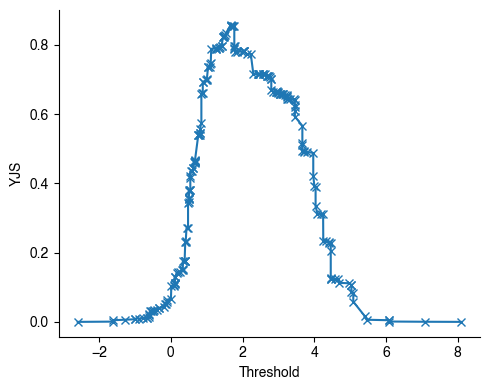

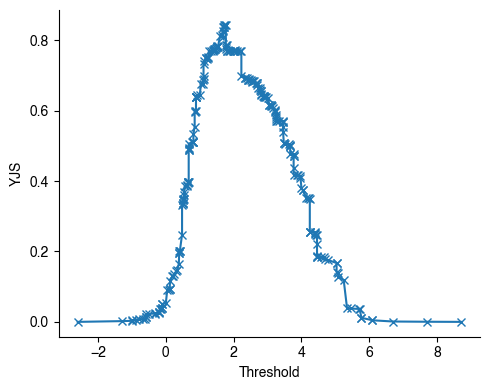

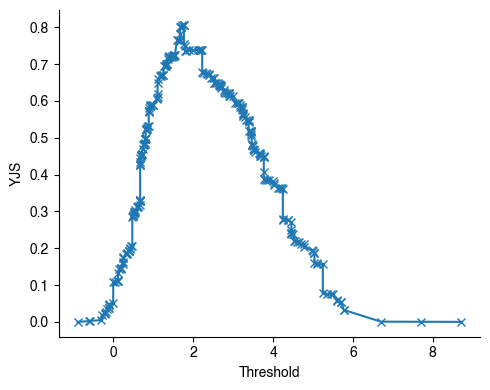

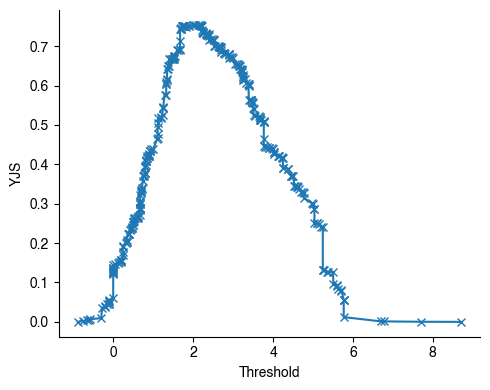

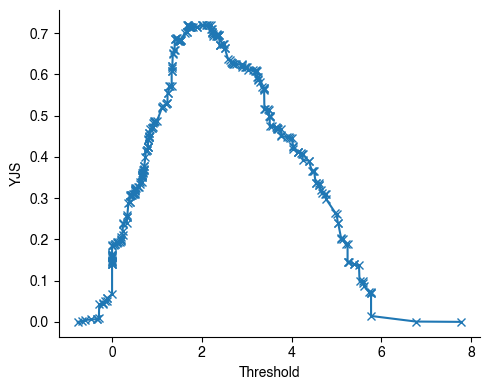

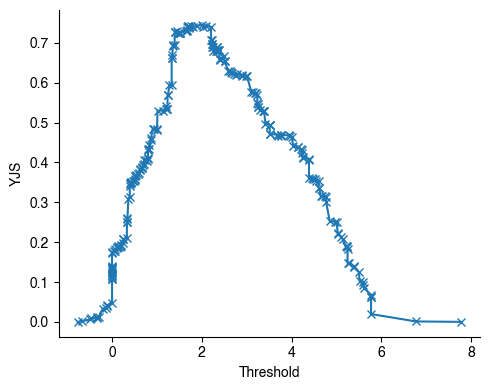

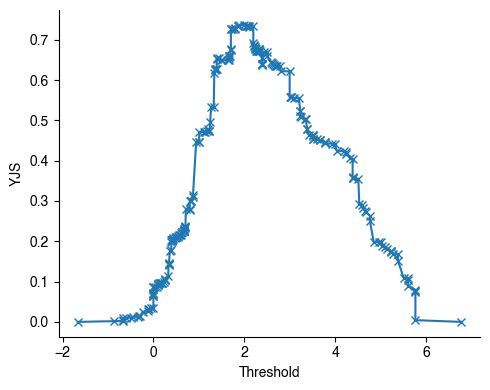

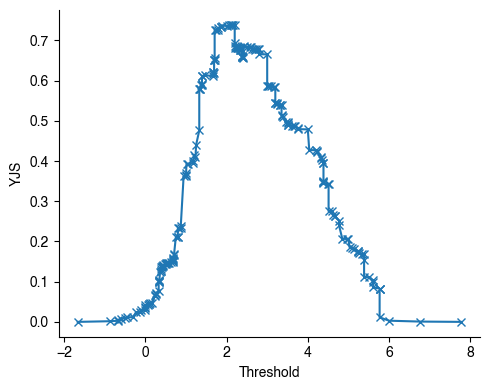

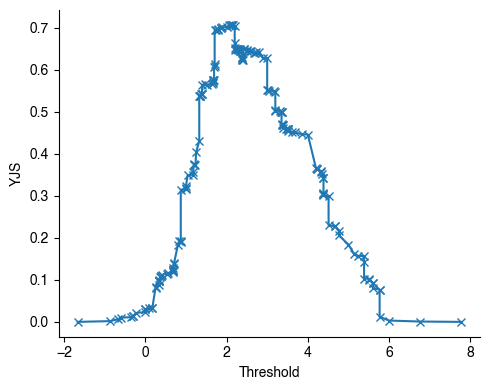

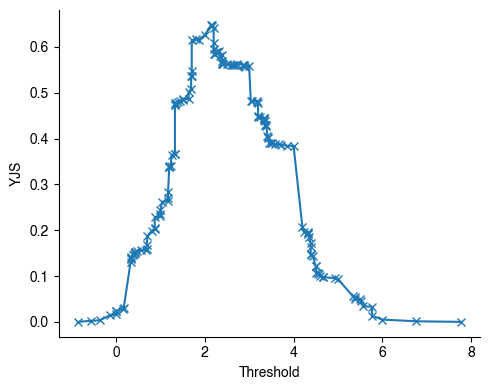

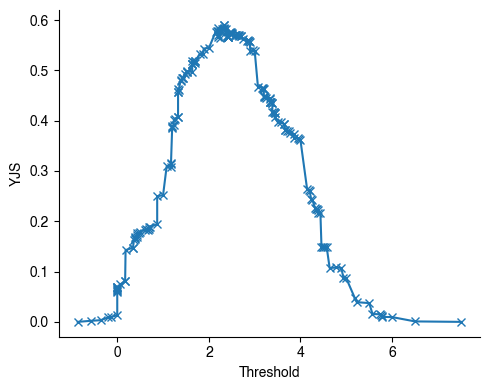

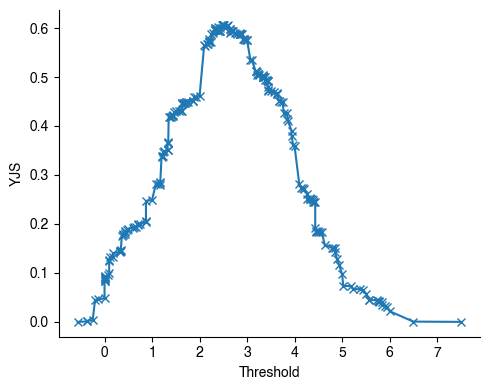

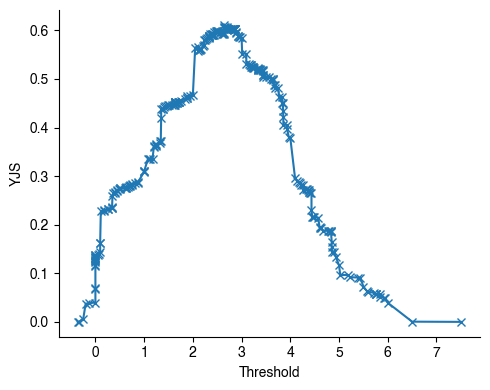

In [5]:
'''
loop over Seasons
'''

data_test_all = pd.DataFrame()
thresholds    = []

for ind, test_season in enumerate(Seasons):
    # skip the validation seasons
    if test_season in ["2012NH", "2012SH", "2013NH", "2013SH"]:
        continue
    
    '''
    assign valid and test datasets as per test season
    '''
    data_test = data[data.season == test_season].copy()
    
    # most recent 3 past seasons
    data_valid_1 = data[data.season == Seasons[ind-3]].copy()
    data_valid_2 = data[data.season == Seasons[ind-2]].copy()
    data_valid_3 = data[data.season == Seasons[ind-1]].copy()
    
    data_valid = pd.concat((data_valid_1, data_valid_2, data_valid_3))
    
    
    '''
    Optimize and apply threshold
    '''
    # if validation dataset include both variants and similar pairs then
    if data_valid.variant.unique().shape[0] > 1:
        '''
        Threshold optimization using Youden’s J statistic
        '''
        yjs_fn = path_result+f"threshold_curves/threshold_curve_YJS_{test_season}.svg"
        threshold_YJS = utilities.youden_threshold(data_valid.variant.values,
                                                   data_valid.predict.values,
                                                   fig_fn=yjs_fn)
    
    else:
        threshold_YJS = ''
    
    
    '''
    Apply threshold on test dataset
    '''
    if threshold_YJS == '':
        data_test["pred_variant_threshold_YJS"] = (data_test.predict.values > 2) * 1
    else:
        data_test["pred_variant_threshold_YJS"] = (data_test.predict.values > threshold_YJS) * 1


    '''
    scores for YJS threshold
    '''
    cols       = ['mut_mat', 'model', 'metadata', 'season']
    col_values = [mut_mat, model_name, metadata, test_season]
    utilities.compute_scores(data_test.nht.values, data_test.predict.values,
                             scores_fn, col=cols, col_val=col_values,
                             y_label=data_test.variant.values,
                             y_pred_label=data_test.pred_variant_threshold_YJS.values)
    
    
    '''
    compile threshold information
    '''
    thresholds.append([test_season, threshold_YJS])
    
    
    '''
    compile data for season, used for average scores
    '''
    data_test_all = pd.concat((data_test_all, data_test))
    
    ##################
    # end seasons loop
    ##################

    
'''
save threshold inforamtion
'''
thresholds = pd.DataFrame(thresholds, columns=["season", "YJS"])
thresholds.to_csv(threshold_fn, index=False)


'''
Micro-average over all test seasons
'''
col_values = [mut_mat, model_name, metadata, "Average"]
utilities.compute_scores(data_test_all.nht.values, data_test_all.predict.values,
                         scores_fn, col=cols, col_val=col_values,
                         y_label=data_test_all.variant.values,
                         y_pred_label=data_test_all.pred_variant_threshold_YJS.values)

## Imports and configuration for plotting

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read test scores and prepare data for plots

In [7]:
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'MCC']

scores = pd.read_csv(scores_fn)
scores = scores[['season']+metrics]

'''
for heatmap change to matrix form
'''
# set season as index
df = scores.set_index('season')

# transpose index and columns
df = df.transpose()

## Plot classification scores per season

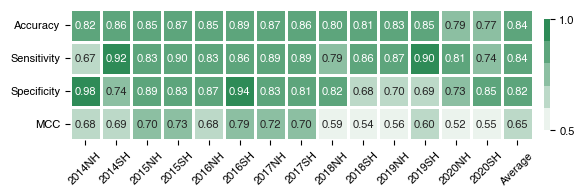

In [8]:
fig, ax = plt.subplots(figsize=(7.2,1.7))

tmp = sns.heatmap(df,
                  annot=True, annot_kws={"size":8}, fmt='.2f',
                  vmin=0.5,
                  vmax=1,
                  cmap=sns.light_palette("seagreen", 5),
                  cbar_kws={"shrink":0.85, "orientation":'vertical', 'pad':0.02},
                  linewidths=1,
                  # square=True,
                  ax=ax)

# configurations for figure
cbar = tmp.collections[0].colorbar
cbar.ax.set_yticks([cbar.ax.get_yticks()[0], cbar.ax.get_yticks()[-1]])

tmp.set_xticklabels(tmp.get_xticklabels(), rotation=45)
ax.set_xlabel("")
ax.set_ylabel("")

# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')